In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import skfuzzy as fuzz
from sklearn.metrics import fowlkes_mallows_score
import math

In [2]:
pd.options.display.max_rows = 25

ratings = pd.read_csv(Path('..','..','res','data','ratings.csv'))

users = pd.read_csv(Path('..','..','res','data','users.csv'))

movies = pd.read_csv(Path('..','..','res','data','movies.csv'))


# zmiana napisów na liczby
label_encoder = LabelEncoder()
users['gender'] = label_encoder.fit_transform(users['gender'])
users['occupation'] = label_encoder.fit_transform(users['occupation'])

In [3]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')

train_set, test_set = train_test_split(ratings_matrix, test_size=0.2)#, random_state=42)
test_set = test_set.fillna(0)
train_set = train_set.fillna(0)
users_train = users[~users['user_id'].isin(test_set.index.to_list())]
items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]

users_test = users[users['user_id'].isin(test_set.index.to_list())]
items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]

train_set.to_csv(Path('..','..','outputs','train_set.csv'), index = False)
test_set.to_csv(Path('..','..','outputs','test_set.csv'), index = False)

In [4]:
def cluster_items(items_info):
    data_to_cluster = items_info[['movie_id','rating']]
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    items_info['cluster'] = clusters
    return(items_info)

In [5]:
def cluster_users(users_info):
    data_to_cluseter = users_info[['age','gender','occupation']]
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
    clusters = kmode.fit_predict(data_to_cluseter) 
    users_info['cluster'] = clusters
    return(users_info)

In [22]:
train_set.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
def IP(train_numpy, items_clustered):
    
    #obliczanie item popularity
    #szukanie IPmax
    IP = np.sum(train_numpy, axis = 0)
    IP = IP.reshape(1,-1)
    IPmax = np.amax(IP)
    IPmax_coordinates = np.argmax(IP) + 1 #bo filmy mają indeksy od 1
    
    #znalezienie clustra IPmax i należących do niego elementów
    IPmax_cluster = items_clustered[items_clustered['movie_id'] == IPmax_coordinates].iloc[0,4]
    max_clust_movies = items_clustered[items_clustered['cluster'] == IPmax_cluster]['movie_id'].to_list()
    max_clust_movies = list(set(max_clust_movies))
    IP_dash = IP[:,np.array(max_clust_movies) - 1] / IPmax
    return(IP_dash, max_clust_movies)
    

In [102]:
def UP_HP(train_set, cluster, clust_data, IP_dash, alpha, selected_movies):
    
    #znalezienie starych użytkowników w danym clustrze
    users_in_cluster = clust_data[clust_data['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))

    #macierz ratingów tylko dla tych userów
    dd = train_set[train_set.index.isin(users_in_cluster)]
    #ratings_matrix_cluster = train_set[train_set.index.isin(users_in_cluster)].to_numpy()
    ratings_matrix_cluster = train_set.loc[train_set.index.isin(users_in_cluster),selected_movies].to_numpy()
    print("aa",ratings_matrix_cluster.shape)
    #obliczanie user popularity
    UP = np.sum(ratings_matrix_cluster, axis=1) ##sumowanie po wierszach
    UP = UP.reshape(-1,1)
    UPmax = np.amax(UP)
    UPmax_coordinates = np.argmax(UP)
    UP_dash = UP / UPmax
    
    # obliczenie UIP i hybrydy
    UIP = UP_dash / IP_dash
    print("bbb", UIP.shape)
    UIP = np.where(ratings_matrix_cluster == 0, 0, UIP)
    HP = alpha * IP_dash + (1-alpha) * np.sum(UIP,axis = 0).reshape(1,-1)
    
    return(HP)

In [104]:
def HP_for_clust(test_set, train_set, alpha):
    
    #zastąpienie nan zerami
    train_set = train_set.fillna(0)
    test_set = test_set.fillna(0)
    train_numpy = train_set.to_numpy()
    test_numpy = test_set.to_numpy()

    #zbiory treningowe
    users_train = users[~users['user_id'].isin(test_set.index.to_list())]
    items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]
    
    #zbiory testowe
    users_test = users[users['user_id'].isin(test_set.index.to_list())]
    items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]
    
    #podział na clustry
    #users_clustered = cluster_users(users_train.copy())
    #items_clustered = cluster_items(items_train.copy())
    
    users_clustered = pd.read_csv(Path('..','..','outputs','users_train_clustered.csv'))
    items_clustered = pd.read_csv(Path('..','..','outputs','items_train_clustered.csv'))
        
    #przypisanie nowych użytkowników do clustrów
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, random_state = 42)#verbose=1, random_state=42) 
    train_clusters = kmode.fit_predict(users_train)
    test_users_clusters = kmode.predict(users_test)
    test_users_clustered = users_test.copy() ##OCEŃ CZY KOPIOWANIE JEST KONIECZNE
    test_users_clustered['cluster'] = test_users_clusters
    IP_results = IP(train_numpy, items_clustered)
    IP_dash = IP_results[0]
    movies_from_max_cluster = IP_results[1]
    print(movies_from_max_cluster)
    clust_HP = {0:None,
                1:None,
                2:None,
                3:None,
                4:None}
    test_set_zero = test_set.copy()
    test_set_zero[:] = 0
    
    concated_users_clustered = pd.concat([users_clustered,test_users_clustered], ignore_index=True)
    train_and_test = pd.concat([train_set, test_set_zero], ignore_index=False)

    for cl in list(set(test_users_clusters)):
        HP = UP_HP(train_and_test, cl, concated_users_clustered, IP_dash, alpha, movies_from_max_cluster)[0].tolist()  
        clust_HP[cl] = (movies_from_max_cluster, HP)
    return(clust_HP, test_users_clustered) #słownik cluster: filmy z clustra gdzie IP_max, HP;
                                            #testoei uzytkownicy z wygenerowanymi klastrami
HP_for_clust(test_set, train_set, 0.5)

[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
aa (314, 21)
bbb (314, 21)
aa (410, 21)
bbb (410, 21)
aa (82, 21)
bbb (82, 21)
aa (99, 21)
bbb (99, 21)
aa (29, 21)
bbb (29, 21)


({0: ([38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58],
   [30.61142631343974,
    29.024516378906625,
    50.34413730277039,
    16.68987877286846,
    22.275079962898992,
    29.086843206843206,
    36.01405005005005,
    27.71452095880667,
    12.66368933868934,
    32.02436314155065,
    15.38003379555104,
    39.29785827398893,
    12.836363636363634,
    47.59783174460594,
    38.20870142870142,
    22.605718792832196,
    28.41333253039135,
    14.807480757713316,
    15.867922850633136,
    49.35269674062776,
    33.027958989164055]),
  1: ([38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58],
   [37.5177340996133,
    67.45100111368406,
    56.53605761267632,
    24.424908691403534,
    39.903824304404345,
    63.34625579425579,
    51.844357742357744,


In [105]:
def create_matrix_for_generated(test_set, train_set, alpha):
    HP_and_clust = HP_for_clust(test_set, train_set, alpha)
    movies_and_HP = HP_and_clust[0] #filmy do polecenia i HP dla każdego clustra
    test_users_with_clusters = HP_and_clust[1]
    num_users_in_clust = test_users_with_clusters.groupby('cluster').agg(users_number = ('cluster','size')).reset_index()
    users_per_cluster = test_users_with_clusters.groupby('cluster')['user_id'].apply(list).to_dict() #uzytkownicy (id) w kazdym clustrze
    num_users_per_cluster = num_users_in_clust.set_index('cluster')['users_number'].to_dict() #liczba użytkowników w każdym clustrze

    test_users_dictionary = {'user_id':[],
                         'movie_id':[],
                         'rating':[]}
    
    for cl in users_per_cluster.keys():
        num_of_users = num_users_per_cluster[cl]
        num_of_items = len(movies_and_HP[cl][0])
        print(num_of_users)
        multiplied_users = users_per_cluster[cl] * num_of_items
        multiplied_users.sort()
        test_users_dictionary['user_id'].extend(multiplied_users)
        #aktualizuję uzytkowników w clustrze powielając ich tyle razy ile jest przedmiotów, 
        #bo każdy musi dany przedmiot mieć oceniony
        users_per_cluster[cl] = multiplied_users

        #powielam przedmioty i oceny tyle razy ilu jest użytkowników
        movies_and_HP[cl] = (movies_and_HP[cl][0] * num_of_users, movies_and_HP[cl][1] * num_of_users)
        test_users_dictionary['movie_id'].extend(movies_and_HP[cl][0])
        test_users_dictionary['rating'].extend(movies_and_HP[cl][1])
        print(movies_and_HP[cl][1])
        test_ratings_HP = pd.DataFrame(test_users_dictionary)
        test_ratings_HP.to_csv(Path('..','..','outputs','test_ratings.csv'), index=False)
        test_ratings_matrix = test_ratings_HP.pivot(index='user_id', columns='movie_id', values='rating')
        test_ratings_matrix = test_ratings_matrix.fillna(0)
        HP_columns = test_ratings_matrix.columns

        test_set_limited = test_set[test_set.columns[test_set.columns.isin(HP_columns)]]
        test_set_limited = test_set_limited.fillna(0)
        test_set_limited.to_csv(Path('..','..','outputs','test_set_limited.csv'), index=False)
    print("aaa",len(list(set(test_users_dictionary['rating']))))
    print("bbb", len(test_users_dictionary['rating']))
    return test_ratings_matrix

create_matrix_for_generated(test_set, train_set, 0.5)


[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
aa (314, 21)
bbb (314, 21)
aa (410, 21)
bbb (410, 21)
aa (82, 21)
bbb (82, 21)
aa (99, 21)
bbb (99, 21)
aa (29, 21)
bbb (29, 21)
95
[30.61142631343974, 29.024516378906625, 50.34413730277039, 16.68987877286846, 22.275079962898992, 29.086843206843206, 36.01405005005005, 27.71452095880667, 12.66368933868934, 32.02436314155065, 15.38003379555104, 39.29785827398893, 12.836363636363634, 47.59783174460594, 38.20870142870142, 22.605718792832196, 28.41333253039135, 14.807480757713316, 15.867922850633136, 49.35269674062776, 33.027958989164055, 30.61142631343974, 29.024516378906625, 50.34413730277039, 16.68987877286846, 22.275079962898992, 29.086843206843206, 36.01405005005005, 27.71452095880667, 12.66368933868934, 32.02436314155065, 15.38003379555104, 39.29785827398893, 12.836363636363634, 47.59783174460594, 38.20870142870142, 22.605718792832196, 28.41333253039135, 14.807480757713316, 15.867922850633136, 49.3526

movie_id,38,39,40,41,42,43,44,45,46,47,...,49,50,51,52,53,54,55,56,57,58
user_id,,,,,,,,,,,,,,,,,,,,,
1,30.611426,29.024516,50.344137,16.689879,22.275080,29.086843,36.014050,27.714521,12.663689,32.024363,...,39.297858,12.836364,47.597832,38.208701,22.605719,28.413333,14.807481,15.867923,49.352697,33.027959
13,19.319541,9.978131,11.480828,25.008810,14.358438,22.780025,15.220050,9.047026,30.737228,15.127346,...,24.685478,6.990741,7.812369,9.243911,11.643270,19.506951,15.466910,8.951773,0.029029,12.399552
20,37.517734,67.451001,56.536058,24.424909,39.903824,63.346256,51.844358,35.065519,76.036816,47.324461,...,35.036039,20.430769,42.479047,49.128379,53.574647,44.001732,43.963529,28.701731,51.171469,44.763872
23,37.517734,67.451001,56.536058,24.424909,39.903824,63.346256,51.844358,35.065519,76.036816,47.324461,...,35.036039,20.430769,42.479047,49.128379,53.574647,44.001732,43.963529,28.701731,51.171469,44.763872
25,0.074575,3.097033,0.034785,0.024274,3.874389,0.025025,0.050050,6.687332,0.014014,5.136623,...,0.049800,1.796875,1.492956,2.466507,5.329588,2.512343,2.430863,1.998964,0.029029,3.550451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,37.517734,67.451001,56.536058,24.424909,39.903824,63.346256,51.844358,35.065519,76.036816,47.324461,...,35.036039,20.430769,42.479047,49.128379,53.574647,44.001732,43.963529,28.701731,51.171469,44.763872
931,19.319541,9.978131,11.480828,25.008810,14.358438,22.780025,15.220050,9.047026,30.737228,15.127346,...,24.685478,6.990741,7.812369,9.243911,11.643270,19.506951,15.466910,8.951773,0.029029,12.399552
934,0.074575,3.097033,0.034785,0.024274,3.874389,0.025025,0.050050,6.687332,0.014014,5.136623,...,0.049800,1.796875,1.492956,2.466507,5.329588,2.512343,2.430863,1.998964,0.029029,3.550451


In [106]:
def find_topN_items(users_ratings,N):

    original_indices = users_ratings.index #oryginalne indeksy
    topN = users_ratings.nlargest(N) #N najlepiej ocenianych filmów (rating i indeks)
    topN_indices = topN.index #indeksy tych najlepiej ocenianych
    zero_mask = users_ratings == 0 #maska do tych miejsc gdzie user_rating jest zero
    zero_indices = users_ratings[zero_mask].index #indeksy tego gdzie jest zero
    mask = users_ratings.index.isin(topN_indices) #maska na te ratingi i indeksy które wchodza w skład topN
    #users_ratings = pd.Series([0 for i in range(len(users_ratings))], index = original_indices)
    #users_ratings[mask] = 1
    #users_ratings[zero_indices] = 0
    
    #print(users_ratings[topN_indices][users_ratings[topN_indices]<5])
    top_nonzero_indices = users_ratings[topN_indices][users_ratings[topN_indices] > 0].index
    users_ratings["topN_movies"] = top_nonzero_indices.values
    
    return users_ratings

In [107]:
def show_Hu(row):
    nonzero = row[row > 0].index
    nonzero_indices = nonzero.values
    row['Hu'] = nonzero_indices
    return row

In [108]:
def NDCG(row,N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    #sprawdzenie który n-ty element z TopN został irl oceniony przez użytkownika
    available_n = [index + 1  for index, element in enumerate(generated) if element in from_test_set]
    DCG = sum([1 / math.log(1+n,2) for n in available_n])
    IDCG = sum([math.log(1+n,2) for n in range(1,N+1)])
    NDCG = DCG / IDCG
    row['NDCG'] = NDCG
    return row

In [109]:
def Precision_Recall(row,N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    intersection = sum([1 for element in generated if element in from_test_set])
    
    Precision = intersection * 100 / N
    row['Precision'] = Precision
    
    row['Recall'] = intersection * 100 / len(from_test_set)
    return row

In [110]:
def nazwepozniej(test_set, train_set, alpha, N):
    generated = create_matrix_for_generated(test_set, train_set, alpha)
    test_set_with_Hu = test_set.apply(lambda row: show_Hu(row), axis = 1)
    generated_topN = generated.apply(lambda row: find_topN_items(row, N), axis = 1)
    
    Hu = test_set_with_Hu.iloc[:,[-1]]
    
    merged = pd.merge(generated_topN, Hu, on='user_id', how = 'left')
    merged = merged.apply(lambda row:  NDCG(row,N),axis = 1)
    merged = merged.apply(lambda row:  Precision_Recall(row,N),axis = 1)
    
    return(merged)

In [111]:
output = nazwepozniej(test_set, train_set, 0.5, 10)

[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
aa (314, 21)
bbb (314, 21)
aa (410, 21)
bbb (410, 21)
aa (82, 21)
bbb (82, 21)
aa (99, 21)
bbb (99, 21)
aa (29, 21)
bbb (29, 21)
95
[30.61142631343974, 29.024516378906625, 50.34413730277039, 16.68987877286846, 22.275079962898992, 29.086843206843206, 36.01405005005005, 27.71452095880667, 12.66368933868934, 32.02436314155065, 15.38003379555104, 39.29785827398893, 12.836363636363634, 47.59783174460594, 38.20870142870142, 22.605718792832196, 28.41333253039135, 14.807480757713316, 15.867922850633136, 49.35269674062776, 33.027958989164055, 30.61142631343974, 29.024516378906625, 50.34413730277039, 16.68987877286846, 22.275079962898992, 29.086843206843206, 36.01405005005005, 27.71452095880667, 12.66368933868934, 32.02436314155065, 15.38003379555104, 39.29785827398893, 12.836363636363634, 47.59783174460594, 38.20870142870142, 22.605718792832196, 28.41333253039135, 14.807480757713316, 15.867922850633136, 49.3526

In [112]:
output['Recall']

user_id
1      3.676471
13     0.471698
20     0.000000
23     0.000000
25     0.000000
         ...   
925    0.000000
931    0.000000
934    0.574713
935    0.000000
941    0.000000
Name: Recall, Length: 189, dtype: float64

<Axes: xlabel='Recall', ylabel='Precision'>

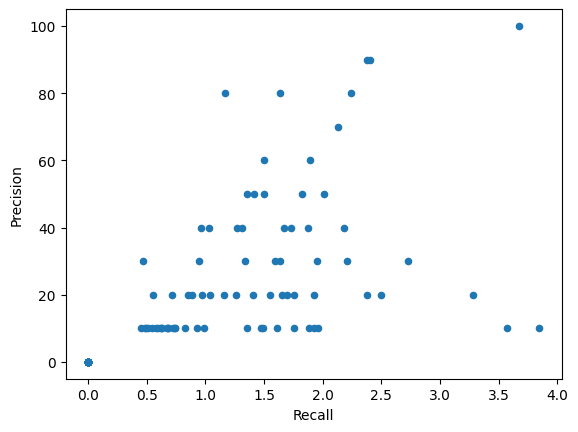

In [114]:
output.plot(x = 'Recall', y = 'Precision', kind = 'scatter')

[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
aa (314, 21)
bbb (314, 21)
aa (410, 21)
bbb (410, 21)
aa (82, 21)
bbb (82, 21)
aa (99, 21)
bbb (99, 21)
aa (29, 21)
bbb (29, 21)
95
[61.073703477730334, 57.94643015521065, 100.61870503597122, 33.33120899718838, 44.33444421008227, 58.12363636363636, 71.928, 55.30641929499072, 25.29935064935065, 63.85653409090911, 30.585893416927906, 78.49611694837826, 24.67272727272727, 95.08705488060328, 76.28727272727271, 45.06579194001875, 56.69903743315508, 29.399746300211415, 31.09320305862363, 98.64733542319748, 65.81918124159138, 61.073703477730334, 57.94643015521065, 100.61870503597122, 33.33120899718838, 44.33444421008227, 58.12363636363636, 71.928, 55.30641929499072, 25.29935064935065, 63.85653409090911, 30.585893416927906, 78.49611694837826, 24.67272727272727, 95.08705488060328, 76.28727272727271, 45.06579194001875, 56.69903743315508, 29.399746300211415, 31.09320305862363, 98.64733542319748, 65.81918124159138

<Axes: xlabel='Recall', ylabel='Precision'>

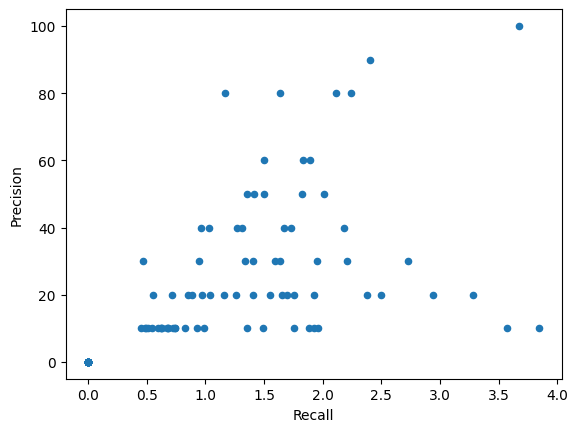

In [115]:
Ioutput = nazwepozniej(test_set, train_set, 0, 10)
Ioutput.plot(x = 'Recall',y = 'Precision', kind = 'scatter')

In [ ]:
Ioutput

In [ ]:
output.loc[[18],[38]]

In [ ]:
sum(output.loc[:,44] != output.loc[18,44])

0

In [45]:
article = pd.read_csv(Path('..','..','res','data','article.csv'))
article

,user_id,movie_id,rating,cluster
0,1,1,3,1
1,1,2,4,1
2,1,3,0,1
3,1,4,5,1
4,1,5,2,1
...,...,...,...,...
23,4,3,0,1
24,4,4,0,1
25,4,5,0,1
26,4,6,0,1


In [46]:
article_matrix = article.pivot(index = 'user_id', columns = 'movie_id', values = 'rating')
article_matrix

movie_id,1,2,3,4,5,6,7
user_id,,,,,,,
1,3,4,0,5,2,0,0
2,0,5,5,4,0,3,3
3,2,3,3,0,2,4,3
4,0,0,0,0,0,0,0


In [48]:
ip_res = IP(article_matrix.to_numpy(), article)

(array([[0.41666667, 1.        , 0.66666667, 0.75      , 0.33333333,
         0.58333333, 0.5       ]]),
 [1, 2, 3, 4, 5, 6, 7])

In [72]:
uip_res = UP_HP(article_matrix, 1, article, ip_res[0], 0.5)
uip_res

pd.DataFrame(ip_res[0])

,0,1,2,3,4,5,6
0,0.416667,1.0,0.666667,0.75,0.333333,0.583333,0.5


In [73]:
pd.DataFrame(uip_res)

,0,1,2,3,4,5,6
0,2.068333,1.775,1.720833,1.508333,2.491667,1.877381,2.1


In [88]:
pd.DataFrame(uip_res).fillna(0)

,0,1,2,3,4,5,6
0,2.068333,1.775,1.720833,1.508333,2.491667,1.877381,2.1


In [90]:
import pandas as pd

# Przykładowe dane
data = {'Kolumna1': [1, 2, 3, 4],
        'Kolumna2': [5, 6, 7, 8]}
df = pd.DataFrame(data)

# Zamień wszystkie elementy na 0
df[:] = 0
print(df)


   Kolumna1  Kolumna2
0         0         0
1         0         0
2         0         0
3         0         0
